In [32]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import stats, signal

import matplotlib.pyplot as plt

from pathlib import Path
import os
import sys

from sklearn.decomposition import PCA, SparsePCA, FastICA, NMF
from sklearn.manifold import Isomap

utils_path = Path("../utils")

sys.path.append(str(utils_path))
sys.path.append(str(utils_path / "data_utils.py"))
sys.path.append(str(utils_path / "train_utils.py"))

from data_utils import process_file, process_all_files

data_path = Path("D:\data_brain_to_text\competitionData")
train_path = data_path / "train"
test_path  = data_path / "test"
holdout_path = data_path / "competitionHoldOut"

fnames_train = os.listdir(train_path)
fnames_test = os.listdir(test_path)
fnames_holdout = os.listdir(holdout_path)

## PCA

In [9]:
%%time
data_res = process_all_files(train_path)

CPU times: total: 14.6 s
Wall time: 35.3 s


In [18]:
fname = fnames_train[0]

brain_list, _, _ = process_file(train_path / fname)

In [19]:
X_concat = np.concatenate(brain_list, axis=0)
X_concat.shape

(158447, 512)

In [21]:
%%time
pca = PCA().fit(X_concat)
X_pca = pca.transform(X_concat)

CPU times: total: 52.5 s
Wall time: 11.4 s


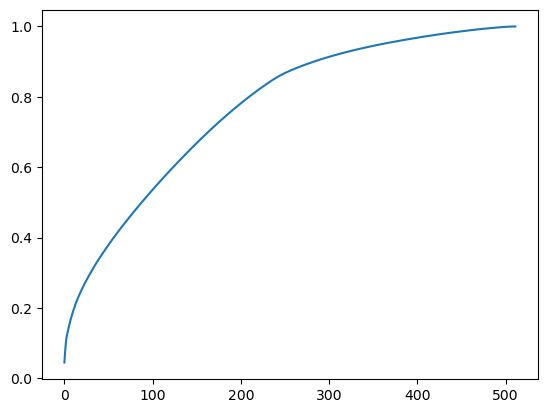

In [23]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [26]:
### ХУЙНЯ

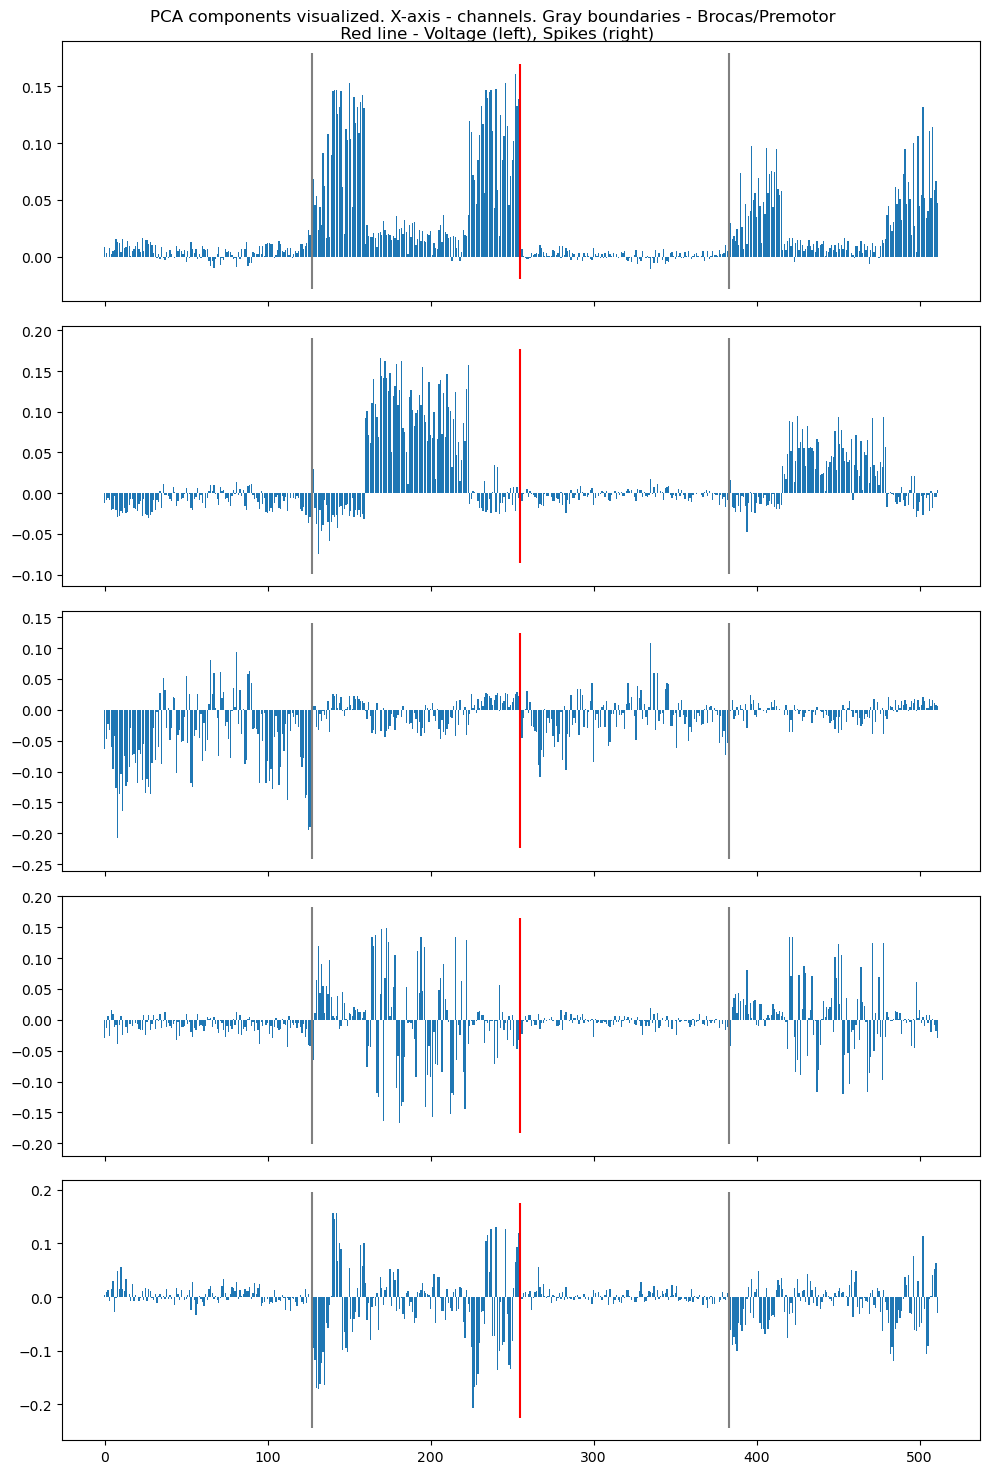

In [33]:
n_comp_show = 5
fig, axes = plt.subplots(n_comp_show, 1, sharex=True, figsize=(10, n_comp_show * 3))
plt.suptitle("PCA components visualized. X-axis - channels. Gray boundaries - Brocas/Premotor \
\n Red line - Voltage (left), Spikes (right)")

chans = np.arange(X_pca.shape[1])
for i in range(n_comp_show):
    ax = axes[i]
    ax.bar(chans, pca.components_[i])
    ax.vlines(255, *ax.get_ylim(), color='red')
    ax.vlines([127, 127 + 256], *ax.get_ylim(), color='gray')
    
plt.tight_layout()

## Isomap

In [3]:
%%time
data_res = process_all_files(test_path)

CPU times: total: 2.16 s
Wall time: 4.67 s


In [4]:
X_concat = np.concatenate(data_res['brain_list'], axis=0)
X_concat.shape

(264472, 512)

In [6]:
%%time
model = Isomap(n_components=80)
model.fit(X_concat)

KeyboardInterrupt: 

## ICA

In [16]:
%%time
data_res = process_all_files(test_path)

X_concat = np.concatenate(data_res['brain_list'], axis=0)
X = X_concat[:, :256]
X_concat.shape

CPU times: total: 2 s
Wall time: 4.06 s


(264472, 512)

## PCA, ICA, NMF

In [19]:
ica = FastICA(n_components=80).fit(X)
X_emb_ica = ica.transform(X)

In [18]:
pca = PCA(n_components=80).fit(X)
X_emb_pca = pca.transform(X)

In [35]:
X_nmf = X - np.min(X)

nmf = NMF(n_components=80).fit(X_nmf)
X_emb_nmf = nmf.transform(X_nmf)

C:\Users\aleks\anaconda3\envs\brain2text\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\aleks\anaconda3\envs\brain2text\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [20]:
X_emb_ica = ica.transform(X)
X_emb_ica.shape

(264472, 80)

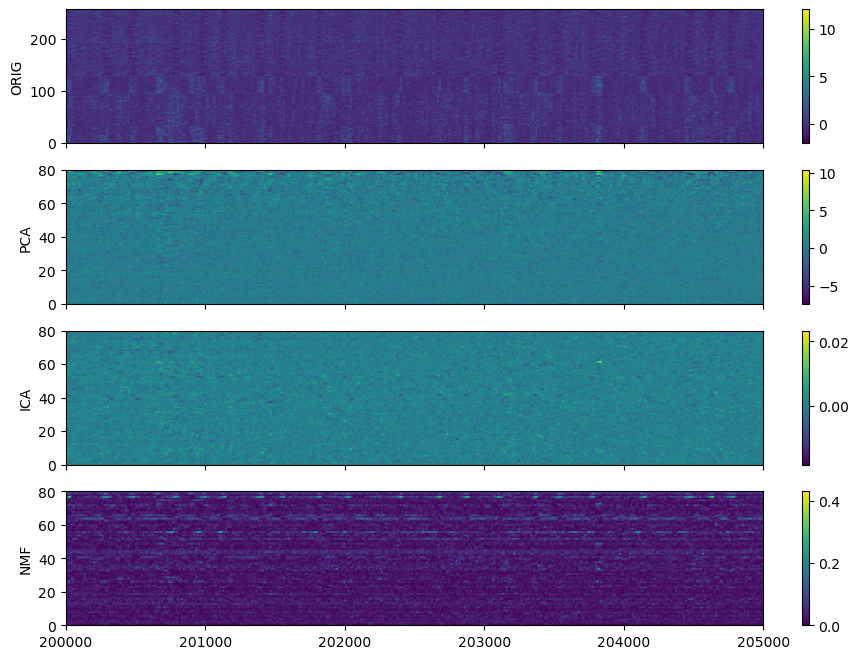

In [63]:
X_emb_list = [X_emb_pca, X_emb_ica, X_emb_nmf]
label_list = ["PCA", "ICA", "NMF"]

t0 = 200000
window_size = 5000

N = len(X_emb_list)
fig, axes = plt.subplots(N + 1, 1, figsize=(10, (N + 1) * 2), sharex=True) #gridspec_kw = dict(height_ratios = [4, 1, 1, 1]))

timeslice = slice(t0, t0 + window_size)

ax = axes[0]
extent = [t0, t0 + window_size, 0, 256]
im = ax.imshow(X[timeslice, :].T, extent=extent, aspect='auto')
ax.set_ylabel("ORIG")
plt.colorbar(im, ax=ax, fraction=0.05)

extent = [t0, t0 + window_size, 0, 80]

for i in range(N):
    ax = axes[i + 1]
    im = ax.imshow(X_emb_list[i][timeslice, :].T, extent=extent, aspect='auto')
    ax.set_ylabel(label_list[i])
    plt.colorbar(im, ax=ax, fraction=0.05)


In [45]:
nmf.reconstruction_err_

3646.541375056644

In [47]:
X_pca_inv = pca.inverse_transform(X_emb_pca)
X_pca_inv.shape

(264472, 256)

In [48]:
np.linalg.norm(X - X_pca_inv)

3635.4314